![caption](images/10Q.png)

## Outline:

#### Note:
1. In the following a "filters" should be understood as not only as matricies, but can also be tensors. 

#### Convolutional neural networks:
1. Classification without neural networks: image input -> Feature vectors -> Classification scheme. With CNNs however we let the network learn the feature vectors by itself. In practice this is done by letting the network learn a series of filters. It is important to note, that the output of applying a filter to an image is an image where each pixel is a linear combination of input image pixel intensities, and the filter kernels weights. Thus a convolutional neural network can be seen as a special case of a FFNN (FFNN with weight-sharing), and trained likewise through backpropagation.
2. As the CNN utlizes the same filter over the whole image the number of parameters are greatly reduces in an CNN copared to a FFNN.
3. An FFNN does not account for the fact, that there is often no correlation between pixels far away from each other.
4. Maxpooling can be explained. Can be used to downsample image when using high enough stride. Ensures that large feature responses are kept in the network.

#### Problem: Classify cancer in tissue
1. Images comming from light microscope. The tissue have been coloured with using a dye giving response to different features in the tissue. The difference between cancer tissue and real tissue is not easy to identify.
2. We will use the VGG19-pretrained netwok. It has been trained on ImageNet. The network will be used as a feature extracter; the last couple of layers are scrapped such that a feautre vector is outputed. KNN-classification (k=5) is then run on theese features.
3. Features will be extracted at different levels, and then we will compare the performance. Target: 85%-ish.

#### Results:
1. The output of the vgg19 model is validated on a dog image. This image is classified as a Labrador Retriever.
2. In our experiments we considered the deep dense layers.
    * The last layer is specialiced for the ImageNet classification. We tested a KNN classifier on this layer as a reference. This showed a surprising 83% accuracy with 1-NN. That is even though the signal in the last layer were very similar to the naked eye.
    * Removing 3 layers (1 dropout, 1 activation, and 1 linear), we had a classification accuracy of 84% with 3-NN.
    * Removing 6 layers (2 dropout, 2 activation, and 2 linear), we had a classification accuracy of 84% with 7-NN.
    
#### Discussion:
A better model can probably be made by training a more sophisticated classifier. Also it should be noted, that the output of the convolutional layers can also be used as featurevectors if flattened.

## Investigate the network:

In [32]:
# Import
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from PIL import Image
from torchvision import transforms
from torchsummary import summary
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests

In [33]:
##################################################
#### Number of layers to remove from vgg19: ######
##################################################

remove_layers = 6 #Try 0, 3 and 6

In [34]:
# Get the pretrained vgg19 network etc.
device = torch.device("cuda:0")
vgg19 = torchvision.models.vgg19(pretrained=True, progress=True).to(device)
vgg19.eval()

# Load dog image as control: Use for validation
dog_im = cv2.imread("dog.jpg")
b,g,r = cv2.split(dog_im)           # get b, g, r
dog_im2 = cv2.merge([r,g,b]) 

# Load dict of one-hot-encoding to labels:
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
# Let's get our class labels.
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
lab = {int(key): value for key, value in response.json().items()}

# Load data:
histo_images = scipy.io.loadmat('histo_images.mat')['histo_images']
histo_labels = scipy.io.loadmat('histo_images.mat')['labels']

# Transpose to format BxCxHxW
histo_x = histo_images.transpose((3,0,1,2))

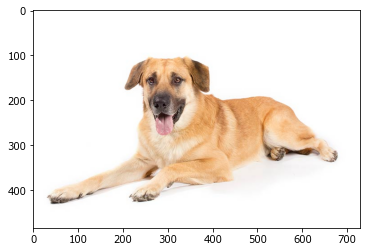

In [35]:
# plot dog:
plt.imshow(dog_im2)

In [36]:
# Send through validation image:
if remove_layers==0:
    preprocess = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
    
    # Pass image through the model:
    item = preprocess(dog_im).unsqueeze(0).to(device)
    if torch.cuda.is_available():
        item = item.to('cuda')
    
    # Pass input through the model
    with torch.no_grad():
        output = vgg19(item)     
    
    prediction = output.data.cpu().numpy().argmax()
    
    print(lab[prediction])


In [37]:
# Print the network:
summary(vgg19, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

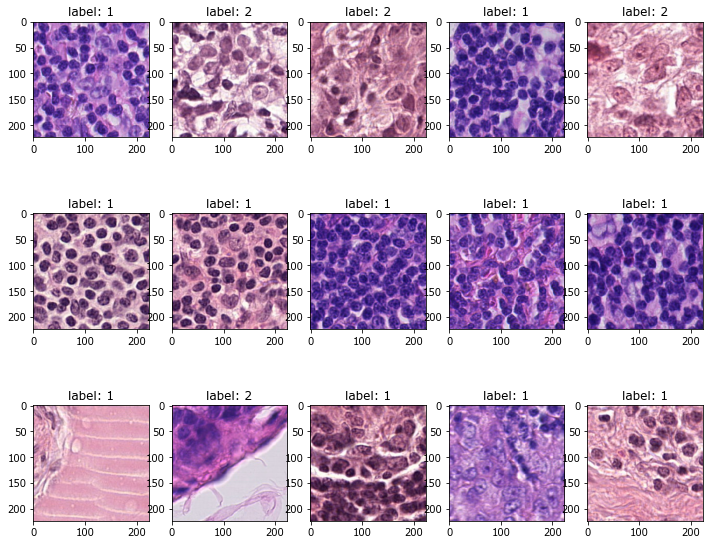

In [38]:
# Checks if images are correctly loaded:
sample = np.random.permutation(histo_images.shape[3])[:15]
fig, ax = plt.subplots(3,5)
fig.set_size_inches(12, 10)
for i in range(3):
    for j in range(5):
        k = j+i*5
        ax[i,j].imshow(histo_images[:,:,:,sample[k]])
        ax[i,j].set_title(f'label: {histo_labels[sample[k]].item()}')

## Modify the network:

In [39]:
# Removes the last layers and define preprocessing: 
if remove_layers==0:
    vgg19.classifier = nn.Sequential(*list(vgg19.classifier.children()))
else:
    vgg19.classifier = nn.Sequential(*list(vgg19.classifier.children())[:-remove_layers])

# Define preprocessing transformations (as specified in torchvision.models):
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Pass all the images through the model:

In [40]:
# Pass image through the model:
item = preprocess(histo_x[0]).unsqueeze(0)
if torch.cuda.is_available():
    item = item.to('cuda')
# Pas input through the model
with torch.no_grad():
    output = vgg19(item)       
    
# Pass the rest of the images through the model:
for i, item in enumerate(histo_x[1:]):
    item = preprocess(item).unsqueeze(0)
    item = item.to('cuda')
    with torch.no_grad():
        output = torch.cat((output, vgg19(item)), axis=0)

In [41]:
# Move features to CPU:
output_np = output.data.cpu().numpy()

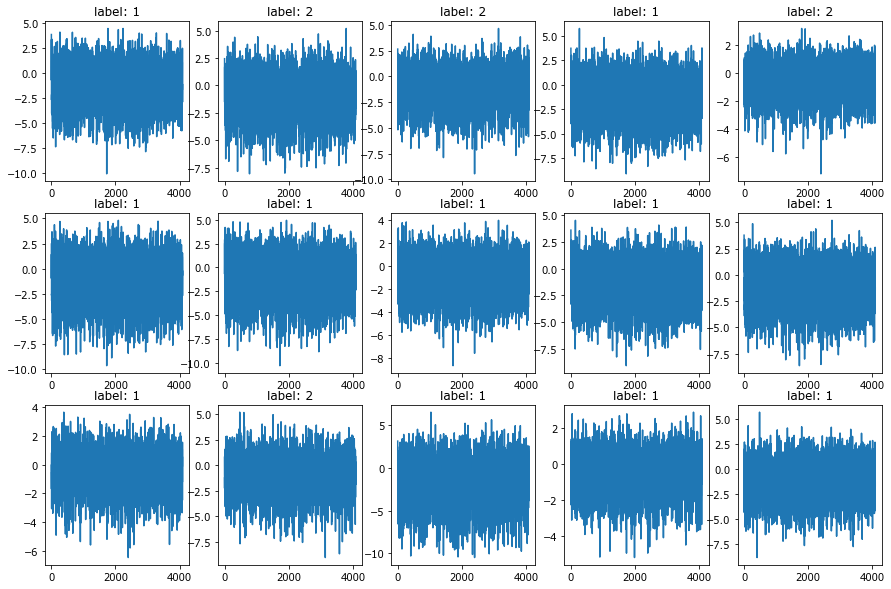

In [42]:
# plot features:
fig, ax = plt.subplots(3,5)
fig.set_size_inches(15,10)
for i in range(3):
    for j in range(5):
        k = j+i*5
        ax[i,j].plot(output_np[sample[k]])
        ax[i,j].set_title(f'label: {histo_labels[sample[k]].item()}')

In [43]:
# We create a general KNN classifier matrix
import sklearn
from sklearn import metrics
# Computing pairwise distances and neighbours 
d2 = sklearn.metrics.pairwise.euclidean_distances(output_np)
S = np.argsort(d2, axis=1) # row-vise ordering, the first column is row index from diagonal, second column is first neighbour etc
L = histo_labels.ravel()[S] # labels of corresponding images

Text(0.5, 1.0, '7 nearest neighbours gives 84% correct predictions')

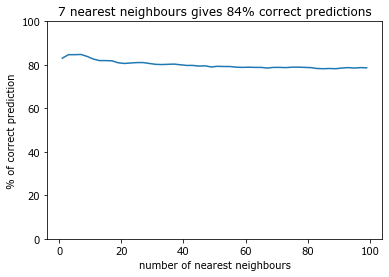

In [44]:
# We find the optimal number of neighbours for the classification: (leave-one-out)
n = np.arange(1,100,2) # only odd number of neighbours for easier majority vote
miss = np.zeros(n.size)
for i in range(n.size): 
    t = L[:,0]
    p = L[:,1:1+n[i]].mean(axis=1).round()
    miss[i] = sum(abs(t-p))

miss /= histo_labels.size
miss *= 100 # miss in pct
hit = 100-miss
istar = np.argmax(hit)

fig, ax = plt.subplots()
ax.plot(n,hit)
ax.set_ylim(0,100)
ax.set_xlabel('number of nearest neighbours')
ax.set_ylabel('% of correct prediction')
ax.set_title(f'{n[istar]} nearest neighbours gives {int(hit[istar])}% correct predictions')